# Importing future models 
- To avoid incompitablity problems we import the four future modules below
- importing all the other required packages

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import time  
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib, copy
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

## To find out the time requried for running a model i created a function 

In [4]:
def run_time(method):
    
    '''defined a function run_time
    for finding the time taken to 
    execute the function'''
    
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed


# Understanding the problem and analysing
- how many readings will a vehicle take to cross
- 1st we build a simple solution 
- given the small sample the avg reading for each  vehicle is well differentiated 
- Create a dataframe for the values given for vehicle prediction


In [16]:
seconds = pd.Series(range(1,18))

amp_read = pd.Series([0.0,-0.05,0.1,0.5,0.4,0.0,1.5,1.55,\
                        1.29,1.62,-0.09,-0.01,5.5,5.66,4.58,0.3,0.2])
 
vehicle = pd.Series(['-','-','-','Motorbike','Motorbike','-',\
                     'Bus','Bus','Bus','Bus','-','-','Car','Car','Car','-','-'])
 
df = pd.concat([seconds,amp_rating,vehicle], axis=1)

df.rename(columns={0:'seconds',1:'amp_read',2:'vehicle'}, inplace = True)

df.head()

,seconds,amp_read,vehicle
0,1,0.00,-
1,2,-0.05,-
2,3,0.10,-
3,4,0.50,Motorbike
4,5,0.40,Motorbike


## we are trying to find the upper and lower boundary by observing mean and standard deviation for vehicle types.
### Then we calculate the -3 and +3 sigma levels and use this for predicting the accuracy, i.e 99%

In [12]:
mean = df[df['vehicle'] != '-'].groupby('vehicle')['amp_read'].mean()
std = df[df['vehicle'] != '-'].groupby('vehicle')['amp_read'].std()
sixsigma = mean - 3 * std, mean + 3 * std
sixsigma

(vehicle
 Bus          1.063620
 Car          3.498067
 Motorbike    0.237868
 Name: amp_read, dtype: float64, vehicle
 Bus          1.916380
 Car          6.995266
 Motorbike    0.662132
 Name: amp_read, dtype: float64)

## creating a new dataframe including the 3 sigma levels 

In [15]:
df1 = df[df['vehicle'] != '-'].groupby('vehicle').describe()['amp_read']

df1['-3 sigma'] = df1['mean'] - 3*df1['std']
df1['3 sigma'] = df1['mean'] + 3* df1['std']
df1

,count,mean,std,min,25%,50%,75%,max,-3 sigma,3 sigma
vehicle,,,,,,,,,,
Bus,4.0,1.490000,0.142127,1.29,1.4475,1.525,1.5675,1.62,1.063620,1.916380
Car,3.0,5.246667,0.582866,4.58,5.0400,5.500,5.5800,5.66,3.498067,6.995266
Motorbike,2.0,0.450000,0.070711,0.40,0.4250,0.450,0.4750,0.50,0.237868,0.662132


## From our new data frame we are considering the +3 and -3 sigma levels as our boundaries for classifying the vehicles

In [17]:
bus_range = [df1.loc['Bus'][8],df1.loc['Bus'][9]]
car_range = [df1.loc['Car'][8],df1.loc['Car'][9]]
bike_range = [df1.loc['Motorbike'][8],df1.loc['Motorbike'][9]]
bike_range

[0.23786796564403578, 0.66213203435596424]

# Assumptions
- The data provided is the sample representation of our data
- range of vehicles does not overlap into each other
- we aim for the 6 sigma approach with an accuracy of 99%

# Constraints
- this works only for the classified data 
- no new vehicle model can be predicted 
- for a continuous data we this model may not work

In [28]:
def vehicle_prediction(unclassified):
    
    '''defined a function vehicle_prediction
    for finding the category in which 
    the vehicle belongs '''
    
    if bike_range[0] <= unclassified['amp_read'] <= bike_range[1]:
        return 'Motorbike'
    elif car_range[0] <= unclassified['amp_read'] <= car_range[1]:
        return 'Car'
    elif bus_range[0] <= unclassified['amp_read'] <= bus_range[1]:
        return 'Bus'
    else:
        return 'Noise or incorrect input values'

In [29]:
unclassified =  {'second':11,'amp_read':0.4}

vehicle_prediction(unclassified)

u'Motorbike'

# Creating a data resembling our sample and we build a machine learning model on it
- creating the data considering the average length of bike-1.8m, car-4.5m, & bus-14m
- given the speed of the vehicles is 15 kmph  i.e is 4.1666 m/s
- let us assume the length of the metal strip is 0.1m and time taken for covering is negligible
- so for bike time taken cover its distance is 1.8/4.166 = 0.432 seconds
- so for car time taken cover its distance is 4.5/4.166 = 1.080 seconds
- so for bike time taken cover its distance is 14/4.166 = 3.360 seconds
- we calculated the average time taken for the vehicles to cover its own length
- now we create a dataset accordingly
# Occurences provide us choice of repetition for vehicles based the typical time taken for the vehicle to cross the metal strip
- we select how many times the vehicles are to appeared every time while crossing the metal strip
- defined a new dataframe accordingly

In [32]:
def occurences(selection):
    if selection == 'Motorbike':
           return np.random.choice([1, 2], p = [0.9, 0.1])
    elif selection == 'Car':
           return np.random.choice([2, 3, 4], p = [0.35, 0.6, 0.05])
    elif selection == 'Bus':
           return np.random.choice([3, 4, 5], p = [0.05, 0.9, 0.05])

In [47]:
def readings(vehicle_type):
    repetition = occurences(vehicle_type)
    vehicle_type_list = repetition*[vehicle_type]
    if vehicle_type == 'Motorbike':
        readings_list = list(np.random.normal(0.5, 0.2, repetition))
    elif vehicle_type == 'Car':
        readings_list = list(np.random.normal(5.5, 0.3, repetition))
    elif vehicle_type == 'Bus':
        readings_list = list(np.random.normal(3.5, 0.4, repetition))
    sample = pd.DataFrame({'vehicle_type':vehicle_type_list,
                         'amp_reading':readings_list})
    return sample

In [48]:
new_df = pd.DataFrame({'vehicle_type': [], 'amp_reading': []})

In [49]:
for count in range(1,301):
    choice = np.random.choice(['Motorbike','Car','Bus'], p=[0.333,0.333,0.334])
    if choice == 'Motorbike':
        new_df = new_df.append(readings(choice))
    elif choice == 'Car':
        new_df = new_df.append(readings(choice))
    elif choice == 'Bus':
        new_df = new_df.append(readings(choice))

In [50]:
new_df = new_df.reset_index(drop=True)

In [51]:
new_df.head()

,amp_reading,vehicle_type
0,0.487826,Motorbike
1,0.672753,Motorbike
2,0.276923,Motorbike
3,5.418279,Car
4,6.115137,Car


# ploting the data set we created and observing how well it is ditributed
- distribution of vehicle type
- distribution of ampere rating

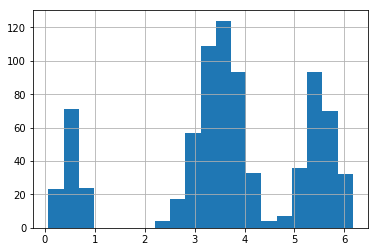

In [52]:
new_df['amp_reading'].hist(bins=20)

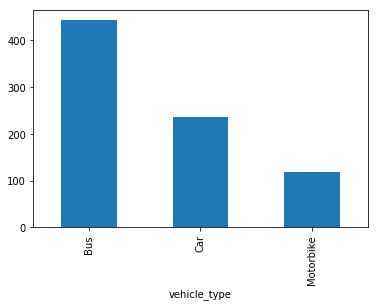

In [53]:

new_df.groupby('vehicle_type').size().plot(kind='bar')

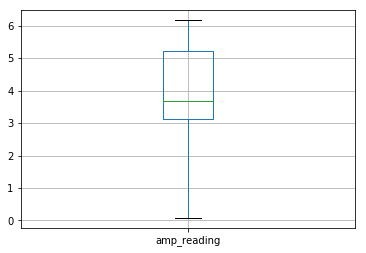

In [54]:
new_df.boxplot(column='amp_reading')

# Creating new features
- created polynomial features x^2, x^3
- captured moving average of 3 ampere readings as bike has atleast 2 consecutive occurences and this will gives the jump in the average as a vehicle has changed
- now this average has been assigned even at the ampere readings are zero or negative values to counter this created a new feature ampere variation where in this problem is solved
- defined our train and target and splited it in the model for prediction
- we predicted the vehicle type and checked for the accuracy score

In [63]:
new_df['amp_square'] = new_df['amp_reading']**2
new_df['amp_cube'] = new_df['amp_reading']**3


s = new_df['amp_reading']
indices = pd.Series(range(new_df['amp_reading'].shape[0]))
new_df['amp_avg_3'] = indices[2:].apply(lambda x: (s[x]+s[x-1]+s[x-2]) / 3 )


# as the first 2 variables will be zero we replace with zero
new_df.amp_avg_3.replace(np.NaN, 0, inplace=True)

new_df['amp_variation'] = new_df['amp_avg_3'] * new_df['amp_reading']

new_df.amp_variation.replace(np.NaN, 0, inplace=True)

In [68]:
X = new_df[['amp_reading','amp_avg_3','amp_square','amp_cube','amp_variation']]
y = new_df['vehicle_type']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [70]:
clf = RandomForestClassifier(oob_score=True, random_state=0)
clf.fit(X_train, y_train)

/home/kakarot/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kakarot/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=0,
            verbose=0, warm_start=False)

In [76]:
predict = clf.predict(X_test)
predict

array([u'Car', u'Bus', u'Motorbike', u'Motorbike', u'Bus', u'Bus', u'Car',
       u'Bus', u'Bus', u'Car', u'Car', u'Bus', u'Bus', u'Car', u'Car',
       u'Car', u'Car', u'Bus', u'Bus', u'Car', u'Bus', u'Car', u'Car',
       u'Bus', u'Car', u'Bus', u'Bus', u'Bus', u'Bus', u'Motorbike',
       u'Bus', u'Bus', u'Bus', u'Bus', u'Bus', u'Motorbike', u'Bus',
       u'Bus', u'Car', u'Car', u'Bus', u'Bus', u'Car', u'Bus', u'Bus',
       u'Bus', u'Bus', u'Bus', u'Bus', u'Motorbike', u'Car', u'Bus',
       u'Bus', u'Bus', u'Bus', u'Bus', u'Bus', u'Car', u'Motorbike',
       u'Car', u'Motorbike', u'Car', u'Bus', u'Motorbike', u'Bus', u'Car',
       u'Car', u'Bus', u'Bus', u'Car', u'Car', u'Car', u'Bus',
       u'Motorbike', u'Car', u'Car', u'Bus', u'Motorbike', u'Car', u'Car',
       u'Bus', u'Car', u'Bus', u'Car', u'Car', u'Car', u'Bus', u'Bus',
       u'Bus', u'Bus', u'Bus', u'Bus', u'Motorbike', u'Bus', u'Bus',
       u'Bus', u'Bus', u'Bus', u'Car', u'Bus', u'Car', u'Bus', u'Car',
       u'Mot

In [77]:
accuracy_score(y_test,predictions)

1.0

# Q 3.3
- here there are multiple detectors of length 1 feet
- typical width of bike is <= 1 feet, and of bus and car is >= 3 feet

# we create new features based on the given information
## creating the data considering the average length of bike-1.8m, car-4.5m, & bus-14m given the speed of the vehicles is 15 kmph i.e is 4.1666 m/s

## for bike
- if a bike passes through a detector we consider the number of consective readings typically a bike take 

- i.e for bike time taken cover its distance is 1.8/4.166 = 0.432 seconds
- and we get reading from a single detector as width is < 1 feet

- occurences: 1(as max time is 0.432 sec less than a second), 
- no. of detector readings simultaneously recorded : 1 (width is < 1 feet)

## for bus
- if a bus passes through a detector we consider the number of consective readings typically a bus take 

- time taken for bus to cover its distance is 14/4.166 = 3.360 seconds
* And we get reading from a atleast three detectors as width is >= 3 feet

- occurences: 4 (as max time is 3.360 seconds), 
- no. of detector readings simultaneously recorded: >= 3 (width is >= 3 feet )

## for car
- if a car passes through a detector we consider the number of consective readings typically a car take 

- time taken by a car to typically cover its distance is 4.5/4.166 = 1.080 seconds
* And we get reading from a atleast three detectors as width is >= 3 feet

- occurences: 2 (as max time is 1.08 seconds), 
- no. of detector readings simultaneously recorded: >= 3 (width is >= 3 feet )

### this classifies the differences between a car bike and bus with multiple detectors

# Q 3.4
- given vehicle speed is 60 kmph
- and thousands of vehicle are passing on the highway

#### we cannot use our previous model because the we build the features based on the time taken for covering the distance by the vehicle itself
#### time take by every vehicle to cross the detector will be same
#### we use average length of bike-1.8m, car-4.5m, & bus-14m given the speed of the vehicles is 60 kmph i.e is 16.66 m/s

- let us calculate the time for the vehicles to cover the distance
- for bike 1.8/16.66 = 0.108 second
- for car 4.5/16.66 = 0.270 second
- for bus 14/16.66 = 0.840 second

#### so every vehicle is taking only less than a second to cross and only we can refer to is the number of detectors recording as the width of the vehicles are different 
#### but again we cannot differentiate between a bus and car 
### final thoughts are the model may not predict accurately as it did in previous case